Idea: https://stepik.org/lesson/532600/step/1?auth=login&unit=717336

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import seaborn as sns
import os
import torch
import random
import torch.optim as optim
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from statistics import mean
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

# Downloading data

In [2]:
# get data files from my github

!git clone https://github.com/NatashaKhotkina/Neural_network_project.git
!cp -r Neural_network_project/data .
!rm -rf Neural_network_project

Cloning into 'Neural_network_project'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 161 (delta 6), reused 24 (delta 6), pack-reused 137
Receiving objects: 100% (161/161), 262.88 MiB | 10.19 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (138/138), done.


In [4]:
path_to_folder = 'data'

In [5]:
list_of_filenames = os.listdir(path_to_folder)
list_of_filenames = sorted(list_of_filenames, reverse=True)

In [6]:
list_of_filenames_test = list_of_filenames[-17:]
list_of_filenames_test

['03122020_Block2_labels.txt',
 '03122020_Block1_labels.txt',
 '03122020_Block15_labels.txt',
 '03122020_Block12_labels.txt',
 '03122020_Block10_labels.txt',
 '01122020_Block9_labels.txt',
 '01122020_Block8_labels.txt',
 '01122020_Block7_labels.txt',
 '01122020_Block6_labels.txt',
 '01122020_Block5_labels.txt',
 '01122020_Block4_labels.txt',
 '01122020_Block3_labels.txt',
 '01122020_Block2_labels.txt',
 '01122020_Block1_labels.txt',
 '01122020_Block12_labels.txt',
 '01122020_Block11_labels.txt',
 '01122020_Block10_labels.txt']

In [ ]:
# makes patches of size 40 with stride 1

def make_patches(voltage, labels, patch_len = 40, stride = 1):
  voltage_patches = []
  length = len(voltage)
  length = length - (length % patch_len)
  for i in range(0, length, stride):
    v_p = voltage[i:i+patch_len]
    l_p = labels[i:i+patch_len]
    if len(l_p) == patch_len:
      voltage_patches.append(v_p)
  return voltage_patches

In [ ]:
# downloads a file and makes patches

def load_group(filename, path_to_folder):
  path_to_file = os.path.join(path_to_folder, filename)
  data = pd.read_csv(path_to_file)
  voltage = torch.tensor(data['Voltage'].values, dtype=torch.float32)
  training_mean = voltage.mean()
  training_std = voltage.std()
  voltage = (voltage - training_mean) / training_std
  labels = data['labels'].to_numpy()
  voltage_patches = make_patches(voltage, labels)
  return voltage_patches

In [ ]:
FILENAME = list_of_filenames_test[0]
list_of_filenames_test[0]

'27102020_Block10_labels.txt'

In [ ]:
X = load_group(FILENAME, path_to_folder)
X = torch.stack(X).unsqueeze(1)

In [ ]:
x_train, x_val = train_test_split(X, train_size=0.9, shuffle=True)
print("Training input shape: ", x_train.shape)

Training input shape:  torch.Size([570234, 1, 40])


In [ ]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=512)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=64)

# Model

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = self.decoder(latent)
    return reconstructed

# Training

In [ ]:
n_epochs = 1
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())


    model.eval()
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses.append(loss.item())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1 [00:00<?, ?it/s]

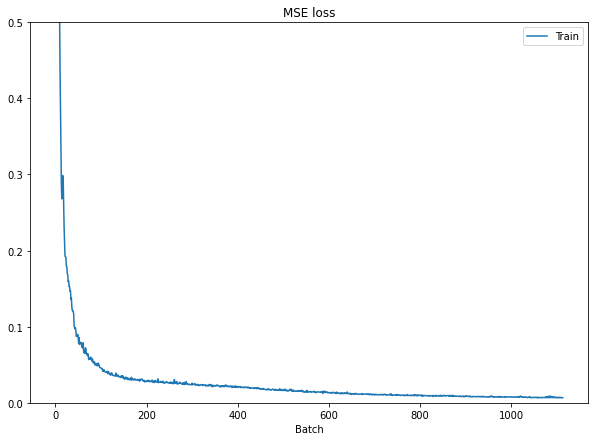

In [ ]:
# train loss after each batch (1 epoch)

plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
#plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.5)
plt.xlabel('Batch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
mean(val_losses) # mean validation loss

0.0370237920564985

# Anomaly detection

In [ ]:
# downloads a file, returns columns "Voltage" as pd.DataFrame, column "labels" as np.ndarray makes patches of voltage

def load_test_group(filename, path_to_folder):
  path_to_file = os.path.join(path_to_folder, filename)
  data = pd.read_csv(path_to_file)
  voltage_pandas = data['Voltage']
  voltage = torch.tensor(data['Voltage'].values, dtype=torch.float32)
  training_mean = voltage.mean()
  training_std = voltage.std()
  voltage = (voltage - training_mean) / training_std
  labels = data['labels'].to_numpy()
  voltage_patches = make_patches(voltage, labels)
  return voltage_pandas, labels, voltage_patches

In [ ]:
voltage_test, labels_test, x_test = load_test_group(FILENAME, path_to_folder)
x_test = torch.stack(x_test).unsqueeze(1)
test_loader = torch.utils.data.DataLoader(x_test, shuffle=False)
print("Test input shape: ", x_test.shape)

Test input shape:  torch.Size([633594, 1, 40])


In [ ]:
# gets MAE loss for each patch (batch_size = 1)

test_losses = []
x_pred = []

with torch.no_grad():
  for batch in test_loader:
    pred = model(batch.to(device)).cpu().numpy()
    mae_loss = np.mean(np.abs(pred - batch.numpy()))
    test_losses.append(mae_loss)
    x_pred.append(pred.ravel())


test_losses = np.array(test_losses).reshape((-1))

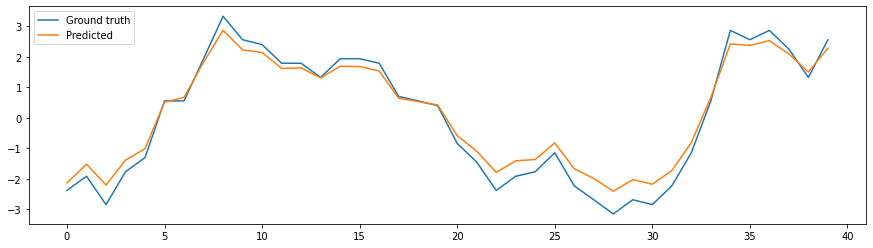

In [ ]:
# Reconstruction

plt.figure(figsize=(15, 4))
plt.plot(X[0].numpy().ravel(), label='Ground truth')
plt.plot(x_pred[0], label='Predicted')

plt.legend()
plt.show()

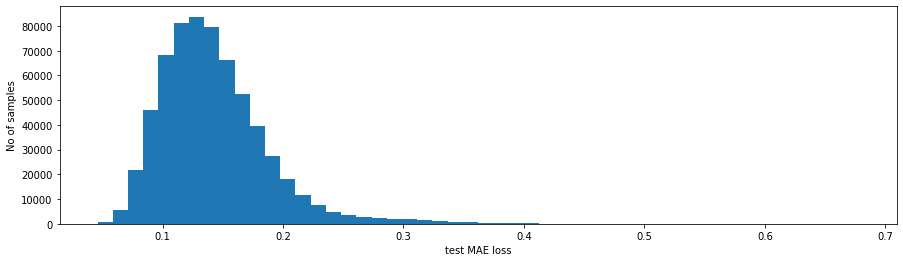

In [ ]:
# Histogram of MAE losses, counted for each patch

plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
max(test_losses)

0.6778058

In [ ]:
np.quantile(test_losses, 0.998)

0.3700464530587213

In [ ]:
threshold = np.quantile(test_losses, 0.998)

In [ ]:
# Those patches, that have MAE loss > threshold, are anomalous - they contain anomalous data.
anomalies = test_losses > threshold

print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  1268
Indices of anomaly samples:  (array([   387,    388,    389, ..., 633558, 633559, 633560]),)


# Graphs

In [ ]:
# data i is an anomaly if samples [(i - TIMESTEPS + 1) to (i)] are anomalies
TIMESTEPS = 20
anomalous_data_indices = []
for data_idx in range(TIMESTEPS - 1, len(voltage_test) - TIMESTEPS + 1):
    if np.all(anomalies[data_idx - TIMESTEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
len(anomalous_data_indices)

270

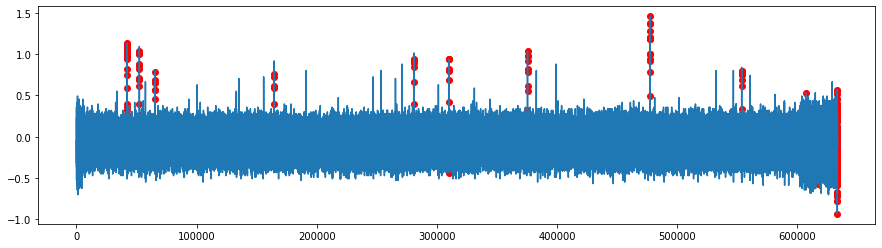

In [ ]:
df_subset = voltage_test.iloc[anomalous_data_indices].to_frame()
fig, ax = plt.subplots(figsize=(15, 4))
voltage_test.plot(legend=False, ax=ax)
plt.scatter(x = df_subset.index, y = df_subset['Voltage'], color="r")
#df_subset.plot(y = df_subset.index, legend=False, ax=ax, color="r", kind='scatter')
plt.show()

# Code for evaluation

In [ ]:
def find_central_index (ind_array):
  #ind_array = ind_array.tolist()
  central_indices = []
  junk_list = []
  lenght = len(ind_array)
  for i, ind in enumerate(ind_array):
    junk_list.append(ind)
    if i < lenght - 1 and (ind_array[i+1] != (ind + 1)):
      central_index = int(mean(junk_list))
      central_indices.append(central_index)
      junk_list = []
  return central_indices

In [ ]:
true_indices = np.where(labels_test == 1)

In [ ]:
a_central_indices = find_central_index(anomalous_data_indices)

In [ ]:
t_central_indices = find_central_index(true_indices[0])

In [ ]:
print(a_central_indices) #predicted
print(len(a_central_indices))

[2476, 41947, 52304, 65180, 164652, 281137, 310243, 375566, 477752, 553916, 607187, 610587, 617450, 627186, 632975, 633348, 633535]
17


In [ ]:
print(t_central_indices) #true
print(len(t_central_indices))

[41951, 52309, 57404, 65190, 100494, 133073, 135133, 155851, 164656, 191240, 246894, 253502, 265608, 271197, 281146, 310251, 331305, 375571, 382919, 399107, 477759, 532687]
22


Precision, recall, F1 are im README.md.